In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from scipy.stats import spearmanr

In [3]:
dataset_path = '../data/model_data.h5'

# Load Data

In [4]:
data = pd.read_hdf(dataset_path, 'no_dummies')

In [5]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
data

,Close,Volume,Open,High,Low,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,...,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,year,month,weekday
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-09,2.107,108772.0,2.103,2.117,2.065,1953071.0,2478.0,2417498.0,93400.0,34.901425,...,-0.003584,-0.003797,-0.005916,-0.036070,-0.015267,-0.006449,0.007501,2012,4,0
2012-04-10,2.031,120126.0,2.111,2.125,2.025,1953071.0,2478.0,2417498.0,93400.0,30.556017,...,-0.006397,-0.004436,-0.006230,-0.023634,-0.008005,0.001807,0.009692,2012,4,1
2012-04-12,1.983,188668.0,1.976,2.068,1.972,1953071.0,2478.0,2417498.0,93400.0,28.170441,...,-0.006395,-0.005282,-0.006237,-0.001009,-0.007785,0.002641,0.011266,2012,4,3
2012-04-13,1.981,111947.0,1.982,1.999,1.959,1953071.0,2503.0,2417498.0,93400.0,28.072097,...,-0.007064,-0.005306,-0.005330,0.017668,-0.005512,0.009896,0.009795,2012,4,4
2012-04-16,2.016,115321.0,1.986,2.030,1.977,1953071.0,2503.0,2417498.0,93400.0,32.512260,...,-0.005926,-0.004447,-0.004609,-0.032242,-0.000894,0.012604,0.010299,2012,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,3.896,54557.0,3.929,3.970,3.884,2218011.0,2851.0,3396062.0,32500.0,50.393336,...,-0.002451,0.003121,0.004626,0.000257,0.023556,0.023485,0.011719,2021,8,1
2021-08-25,3.897,37979.0,3.900,3.991,3.858,2218011.0,2851.0,3396062.0,32500.0,50.456830,...,-0.000895,0.002589,0.004246,0.073646,0.034399,0.025870,0.013270,2021,8,2
2021-08-26,4.184,64362.0,3.917,4.217,3.896,2218011.0,2851.0,3396062.0,32500.0,64.500602,...,0.001622,0.003632,0.005519,0.044455,0.020949,0.016707,0.014884,2021,8,3


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2351 entries, 2012-04-09 to 2021-08-30
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Close                          2351 non-null   float64
 1   Volume                         2351 non-null   float64
 2   Open                           2351 non-null   float64
 3   High                           2351 non-null   float64
 4   Low                            2351 non-null   float64
 5   Consumption in mcf             2351 non-null   float64
 6   Storage in mcf                 2351 non-null   float64
 7   US Gross Withdrawal in mcf     2351 non-null   float64
 8   Other Gross Withdrawal in mcf  2351 non-null   float64
 9   RSI                            2351 non-null   float64
 10  ATR                            2351 non-null   float64
 11  MACD                           2351 non-null   float64
 12  return_1d                     

In [7]:
def get_X_y(data: pd.DataFrame):
    columns_to_drop = ['Open', 'Close', 'Low', 'High', 'Volume']
    y = data.filter(like='target')
    X = data.drop(columns_to_drop, axis=1)
    X = X.drop(y.columns, axis=1)
    return X, y

In [8]:
X, y = get_X_y(data)

In [9]:
X, X_test, y, y_test = X.loc['2012':'2019'], X.loc['2019':'2021'], y.loc['2012':'2019'], y.loc['2019':'2021']

In [10]:
f'Train lenght: {len(X)}', f'Test length: {len(X_test)}'

('Train lenght: 1932', 'Test length: 671')

In [11]:
X_test

,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,ATR,MACD,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,year,month,weekday
Date,,,,,,,,,,,,,,,,
2019-01-02,3409295.0,2705.0,3384552.0,40363.0,33.538191,0.299760,-0.233675,0.006122,-0.031256,-0.017467,-0.020928,-0.002319,-0.001078,2019,1,2
2019-01-03,3409295.0,2705.0,3384552.0,40363.0,33.358741,0.287848,-0.258615,-0.004395,-0.036298,-0.026137,-0.018285,-0.002248,-0.001465,2019,1,3
2019-01-04,3409295.0,2614.0,3384552.0,40363.0,36.160111,0.278359,-0.267889,0.033616,-0.035236,-0.020013,-0.017993,-0.001805,-0.000619,2019,1,4
2019-01-07,3409295.0,2614.0,3384552.0,40363.0,34.578907,0.268048,-0.279667,-0.032852,-0.022750,-0.019451,-0.019680,-0.004560,-0.001038,2019,1,0
2019-01-08,3409295.0,2614.0,3384552.0,40363.0,35.279894,0.256687,-0.284057,0.007812,0.001830,-0.024851,-0.017807,-0.004296,-0.001528,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,2218011.0,2851.0,3396062.0,32500.0,50.393336,0.132758,0.022960,-0.012421,0.003057,-0.004823,-0.002451,0.003121,0.004626,2021,8,1
2021-08-25,2218011.0,2851.0,3396062.0,32500.0,50.456830,0.132775,0.019566,0.000257,0.002326,-0.004065,-0.000895,0.002589,0.004246,2021,8,2
2021-08-26,2218011.0,2851.0,3396062.0,32500.0,64.500602,0.146220,0.038202,0.073646,0.017838,0.006206,0.001622,0.003632,0.005519,2021,8,3


In [12]:

class MultipleTimeSeriesCV(BaseCrossValidator):
    """Generates tuples of train_idx, test_idx pairs"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Date > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [13]:
n_splits = 15
train_period_length = 300
test_period_length = 100
lookaheads = [1, 5, 10, 21]

In [14]:
# Utilities functions

def display_score(scores):
    print('scores: ',scores)
    print('mean: ', scores.mean())
    print('standard deviation: ', scores.std())


def rank_correl(y, y_pred):
    return spearmanr(y, y_pred, axis=None)[0]

ic = make_scorer(rank_correl)


def get_cross_val_score(model, X, y, score_fun, cv, n_jobs=-1):
    cv_score = cross_val_score(estimator=model,
                           X=X,
                           y=y,
                           scoring=score_fun,
                           cv=cv,
                           n_jobs=n_jobs,
                           verbose=1)
    display_score(cv_score)

# Decision Tree Regressor

In [15]:
dt_reg = DecisionTreeRegressor(max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto')


In [16]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(dt_reg, X, y, ic, cv)
    print('\n')

lookhead: 1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.09727688  0.15991531  0.10903402 -0.12767872  0.05605538  0.08767445
  0.11047236  0.05198236 -0.06288318  0.07258711  0.1580181   0.13827551
  0.02744095  0.03450539  0.24855148]
mean:  0.06444490822691186
standard deviation:  0.0978769915640111


lookhead: 5


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.23932865  0.04355676  0.10955611 -0.06914116  0.0687488   0.20753994
  0.08159278  0.27209771 -0.02431577  0.10916383 -0.07221549 -0.12106421
  0.12674053  0.03444469  0.00063933]
mean:  0.03520101469775931
standard deviation:  0.12529835400507383


lookhead: 10
scores:  [-0.20894333  0.09282725  0.16560294 -0.07131381 -0.01160693  0.0286076
  0.08017568  0.18480282  0.03997471  0.15525412  0.16975387 -0.03697229
  0.1038723   0.02238111  0.01579173]
mean:  0.048680518532065925
standard deviation:  0.10269551962534071


lookhead: 21
scores:  [-0.14649716  0.08570183  0.08754996  0.09897389 -0.00525868 -0.04747947
  0.03641507  0.05183396 -0.03055383  0.08428779  0.04881495  0.03256081
  0.07822132 -0.07325524  0.04406189]
mean:  0.023025139684977984
standard deviation:  0.06807686285128438




[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


# Random Forest Regressor

In [17]:
rf_reg = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=None,
                                verbose=0,
                                warm_start=False)

In [18]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(rf_reg, X, y, ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.12108694  0.29564089  0.31626222 -0.08394972  0.10184914  0.23538785
  0.1473978   0.13939381  0.02573623  0.18346869  0.03066282  0.165713
  0.08559691  0.11646392  0.1919367 ]
mean:  0.12203155351148723
standard deviation:  0.11920608269971561


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.16952131  0.318056    0.28133917 -0.10865543  0.10946468  0.19299158
  0.09924374  0.12386327  0.00102657  0.10407712  0.02004988  0.15678251
  0.09371609  0.10037219  0.16722423]
mean:  0.09933535289072176
standard deviation:  0.12380062470098703


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.15700148  0.31559439  0.24738204 -0.05945906  0.05716104  0.07265633
  0.12838321  0.1824002   0.11605031  0.08786633  0.02483041  0.16788971
  0.10117676  0.08219958  0.07315264]
mean:  0.0960188269786027
standard deviation:  0.10994641303553458


lookhead: 21
scores:  [-0.17031856  0.32282294  0.20207667  0.11960982  0.1138224   0.04699811
  0.06634431  0.10673223  0.09167365  0.10809734  0.03199764  0.10308948
  0.07945175  0.16502034  0.07294377]
mean:  0.09735745749058254
standard deviation:  0.09924736746568662




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.8s finished


# Ada Boosting Regressor

In [19]:
ada_reg = AdaBoostRegressor(n_estimators=100,
                            loss='square')

In [20]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(ada_reg, X, y[f'target_{lookahead}d'], ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.12091993 -0.0603907   0.12123377 -0.01948371 -0.09640779  0.04495445
  0.10760744 -0.0469968   0.00099652  0.03677962 -0.00972184 -0.07076238
  0.04573316  0.08059551  0.10594346]
mean:  0.007944051211345485
standard deviation:  0.07473038147678282


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.32223882  0.04272299  0.35237593  0.09958874  0.05105684  0.24480381
  0.00948416  0.16768959  0.12507282  0.04305151  0.00177086  0.07281967
 -0.07468331  0.09189324  0.05133409]
mean:  0.06378280770046398
standard deviation:  0.14351102603478047


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.10000451  0.4429515   0.07864438  0.32486494  0.21585433  0.22848329
  0.15312166  0.06206953  0.38328569  0.0802445   0.27941687 -0.01101601
 -0.13235242  0.39098803  0.0034872 ]
mean:  0.16000259807427494
standard deviation:  0.17549100725766204


lookhead: 21
scores:  [-0.33381886  0.49359571  0.21023756  0.28065743  0.24402644  0.67251475
  0.07781936 -0.36436447  0.05120837  0.08073295  0.06313673  0.73728847
 -0.03717035  0.7342632  -0.09185038]
mean:  0.18788512751983158
standard deviation:  0.3371301813375886




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished


# Gradient Boosting Regressor

In [21]:
grad_reg = GradientBoostingRegressor(n_estimators=250,
                                        max_depth=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        random_state=None,
                                        verbose=0,
                                        warm_start=False)

In [22]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(grad_reg, X, y[f'target_{lookahead}d'], ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.20248486  0.00258026  0.16319428 -0.00112812  0.00928893  0.19884788
  0.00917495  0.01730573  0.05342398  0.26478248  0.01636964 -0.03168326
  0.10649961  0.1659646  -0.02244224]
mean:  0.049979589930176274
standard deviation:  0.11069694576501679


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.45548185  0.08672067 -0.0230979  -0.18267027  0.00129613  0.11798521
 -0.04574871  0.17799033 -0.04453139  0.09592559  0.14234794 -0.05026103
  0.15423942 -0.0140174  -0.00747675]
mean:  -0.0031186656274374857
standard deviation:  0.15372095726554577


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.27749508  0.25120164  0.07259548 -0.0563518   0.15735468  0.19720372
  0.12241224 -0.07194871  0.50045755 -0.01042904  0.22860298 -0.14250524
  0.06419538  0.18031911 -0.22591059]
mean:  0.06598015452593105
standard deviation:  0.19627652152616937


lookhead: 21
scores:  [-0.15728867  0.04502864  0.22202353  0.1940474   0.26275428  0.44307964
 -0.4009385  -0.55066802  0.35607668 -0.06651725 -0.11976008 -0.11341134
 -0.01308778  0.20507651  0.45928406]
mean:  0.051046605669372504
standard deviation:  0.2846712026006301




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished


It seems like that the most robust learner is the `RandomTreesRegressor`, since there is not much deviation using the
various targets. Let's fine tune it in order to find the bests parameters

## Hyperparamter Options

In [23]:
n_estimators = [100, 250]
max_depth = [5, 15, None]
min_samples_leaf = [5, 25, 100]

In [24]:
from itertools import product

cv_params = list(product(n_estimators,
                         max_depth,
                         min_samples_leaf))
n_cv_params = len(cv_params)
n_cv_params

18

In [25]:
sample_proportion = .6
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)),
                                     size=int(sample_size),
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 10


## Train/Test Period Lenghts

In [26]:
YEAR = 252
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

In [27]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)
print('# period params: ', n_test_params)

# period params:  10


## Run cross-validation

In [28]:
labels = sorted(y.columns)
features = X.columns.tolist()
lookaheads = [1, 5, 10, 21]

In [29]:
label_dict = dict(zip(lookaheads, labels))

In [30]:
cross_val_cols = [
    'train_length',
    'test_length',
    'n_estimators',
    'max_depth',
    'min_samples_leaf',
    'mean_ic',
    'std_ic',
    'rounds',
    'target'
]

cross_val_results = pd.DataFrame(columns=cross_val_cols)

In [31]:
run_cross_val = False

if run_cross_val:
    for lookahead in lookaheads:
        for train_length, test_length in test_params:
            n_splits = int(7 * YEAR / (train_length + test_length))
            res_row = dict(zip(cross_val_results, [None] * len(cross_val_results)))

            cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                      test_period_length=test_length,
                                      train_period_length=train_length,
                                      lookahead=lookahead)

            res_row['target'] = lookahead
            res_row['train_length'] = train_length
            res_row['test_length'] = test_length


            for p, (n_estimator, max_d, min_s_l) in enumerate(cv_params_):
                base_params = rf_reg.get_params()
                model = RandomForestRegressor(base_params)
                model_params = {
                    'n_estimators': n_estimator,
                    'max_depth': max_d,
                    'max_features': 'log2',
                    'min_samples_leaf': min_s_l
                }
                model = model.set_params(**model_params)

                cval_score = cross_val_score(
                    estimator=model,
                    X=X,
                    y=y,
                    cv=cv,
                    n_jobs=-1,
                    scoring=ic
                )

                for k, v in model_params.items():
                    res_row[k] = v

                res_row['mean_ic'] = cval_score.mean()
                res_row['std_ic'] = cval_score.std()
                res_row['rounds'] = len(cval_score)
                cross_val_results = cross_val_results.append(res_row, ignore_index=True)
                print(f'Lookback: {lookahead}, Train size: {train_length}, Test size: {test_length} ' + \
                      f'# estimators: {n_estimator}, max depth: {max_d}, min samples leaf: {min_s_l}, ic: {cval_score.mean()}')

In [32]:
save = False

if save:
    cross_val_results.to_hdf('./rf_cross_val_results.h5', 'res', mode='w')

In [33]:
load = True

if load:
    cross_val_results = pd.read_hdf('./rf_cross_val_results.h5', 'res')
    cross_val_results.drop('max_features', axis=1, inplace=True)

In [34]:
cross_val_results.head()

,train_length,test_length,n_estimators,max_depth,min_samples_leaf,mean_ic,std_ic,rounds,target
0,1260,5,100,None,100,0.452632,0.0,1,1
1,1260,5,100,None,5,0.383459,0.0,1,1
2,1260,5,250,5,100,0.500752,0.0,1,1
3,1260,5,250,15,25,0.407519,0.0,1,1
4,1260,5,100,None,25,0.479699,0.0,1,1


# Hyperparameters Analysis

Now that we have our cross validation results, let's see which hyperparameters combination gives us the best results in
various target periods.

First thing first, we would like to understand which train and test period lengths gives the best results. We can do it
by grouping by the `train_length` and `test_length`.

In [35]:
tt_lenght_res = cross_val_results.groupby(by=['train_length', 'test_length'])

tt_lenght_res.describe()

mean_ic                                          \
                           count      mean       std       min       25%   
train_length test_length                                                   
63           5              40.0 -0.067284  0.125394 -0.238227 -0.198366   
             21             40.0  0.013003  0.045987 -0.059556 -0.031805   
126          5              40.0  0.037978  0.095936 -0.179574 -0.037138   
             21             40.0  0.034013  0.031098 -0.029292  0.013257   
252          5              40.0  0.099102  0.146178 -0.118797 -0.035965   
             21             40.0 -0.004490  0.070845 -0.100003 -0.059219   
756          5              40.0  0.186015  0.115528 -0.008271  0.110150   
             21             40.0  0.201002  0.105924  0.005477  0.111770   
1260         5              40.0  0.433759  0.144668 -0.111278  0.372932   
             21             40.0  0.362641  0.080246  0.172502  0.317272   

                                                       std_ic            \
                               50%       75%       max  count      mean   
train_length test_length                                                  
63           5           -0.060339  0.040526  0.175820   40.0  0.323679   
             21           0.020466  0.051996  0.087472   40.0  0.141557   
126          5            0.068006  0.099740  0.182765   40.0  0.308713   
             21           0.033019  0.056213  0.100750   40.0  0.142778   
252          5            0.088972  0.240602  0.344110   40.0  0.226119   
             21          -0.007356  0.033678  0.198329   40.0  0.175353   
756          5            0.192105  0.265226  0.460150   40.0  0.184398   
             21           0.197202  0.285152  0.395819   40.0  0.053943   
1260         5            0.475188  0.501128  0.658647   40.0  0.000000   
             21           0.368462  0.428501  0.512524   40.0  0.000000   

                                                                            \
                               std       min       25%       50%       75%   
train_length test_length                                                     
63           5            0.038303  0.247583  0.291036  0.332345  0.355690   
             21           0.029460  0.102602  0.110236  0.143732  0.159184   
126          5            0.047910  0.210200  0.281005  0.313996  0.345437   
             21           0.035196  0.089118  0.103313  0.151955  0.172974   
252          5            0.085731  0.057937  0.154616  0.235666  0.275010   
             21           0.064942  0.074036  0.093632  0.202344  0.219997   
756          5            0.117764  0.005263  0.063910  0.192105  0.283083   
             21           0.033933  0.003493  0.023585  0.055524  0.073221   
1260         5            0.000000  0.000000  0.000000  0.000000  0.000000   
             21           0.000000  0.000000  0.000000  0.000000  0.000000   

                                    
                               max  
train_length test_length            
63           5            0.389807  
             21           0.204857  
126          5            0.395579  
             21           0.196788  
252          5            0.403241  
             21           0.280459  
756          5            0.420301  
             21           0.146188  
1260         5            0.000000  
             21           0.000000

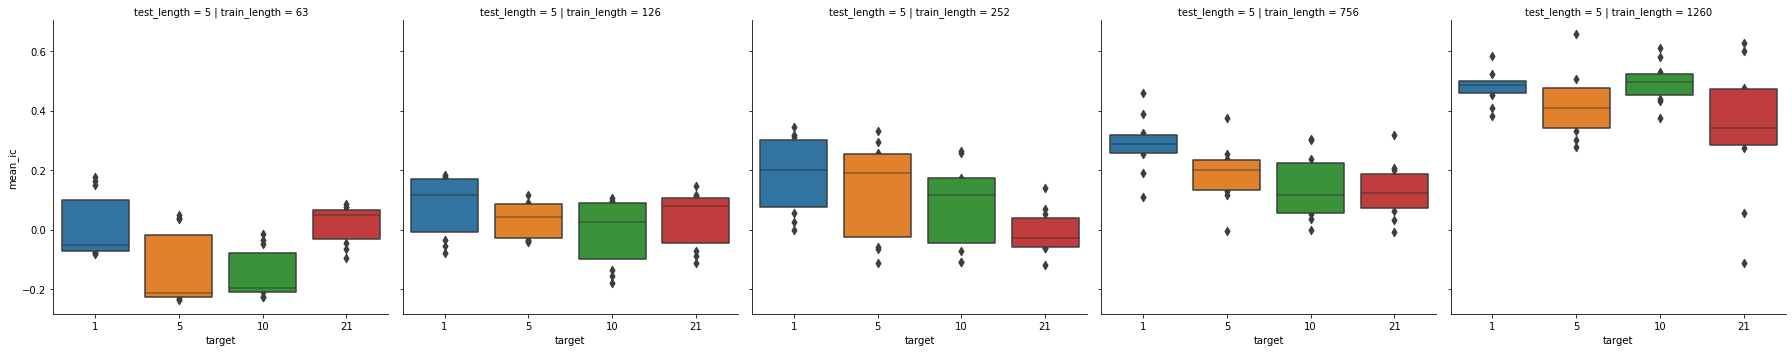

In [36]:
sns.catplot(x='target',
            y='mean_ic',
            col='train_length',
            row='test_length',
            data=cross_val_results[(cross_val_results.test_length == 5)],
            kind='boxen')

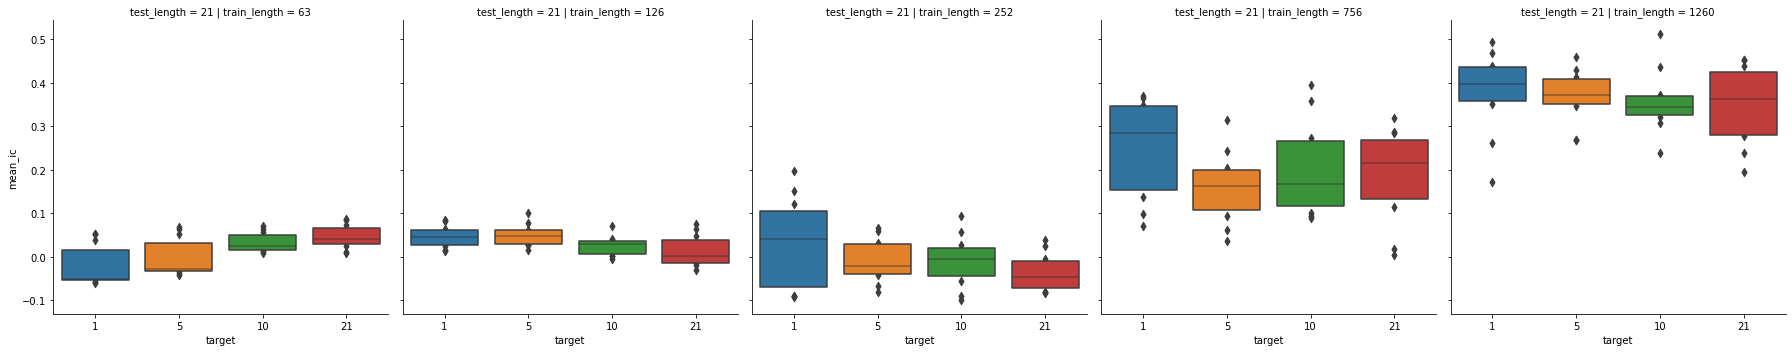

In [37]:
sns.catplot(x='target',
            y='mean_ic',
            col='train_length',
            row='test_length',
            data=cross_val_results[(cross_val_results.test_length == 21)],
            kind='boxen')

As we can see the longer the train periods are the better, the `mean_ic` steadly grows as the train period grows. If
we look also to the test period the previous logic is still true.

Regarding the standard deviation of the `ic` we can see a great decrease when the test length is longer, while the
train period doesn't seem to affect positively the standard deviation.

In [38]:
hyperparam_res = cross_val_results.groupby(by=['n_estimators', 'max_depth', 'min_samples_leaf'])

hyperparam_res.describe()

mean_ic                                \
                                          count      mean       std       min   
n_estimators max_depth min_samples_leaf                                         
100          5         5                   40.0  0.163846  0.201405 -0.118797   
             15        100                 40.0  0.079941  0.200398 -0.232050   
250          5         25                  40.0  0.179947  0.204978 -0.238227   
                       100                 40.0  0.079941  0.195033 -0.227706   
             15        25                  40.0  0.163369  0.190010 -0.219790   

                                                                       \
                                              25%       50%       75%   
n_estimators max_depth min_samples_leaf                                 
100          5         5                 0.050695  0.096760  0.215230   
             15        100              -0.049119  0.011794  0.177161   
250          5         25                0.026122  0.118292  0.326174   
                       100              -0.061148  0.012908  0.191917   
             15        25                0.024417  0.158638  0.303822   

                                                  std_ic                      \
                                              max  count      mean       std   
n_estimators max_depth min_samples_leaf                                        
100          5         5                 0.658647   40.0  0.173000  0.121530   
             15        100               0.578947   40.0  0.114938  0.110497   
250          5         25                0.512524   40.0  0.165795  0.128020   
                       100               0.500752   40.0  0.114934  0.106385   
             15        25                0.609023   40.0  0.168495  0.127481   

                                                                            \
                                         min       25%       50%       75%   
n_estimators max_depth min_samples_leaf                                      
100          5         5                 0.0  0.097395  0.158642  0.281585   
             15        100               0.0  0.020402  0.091188  0.163174   
250          5         25                0.0  0.019220  0.168670  0.261642   
                       100               0.0  0.038048  0.093593  0.136679   
             15        25                0.0  0.014762  0.165836  0.273214   

                                                   
                                              max  
n_estimators max_depth min_samples_leaf            
100          5         5                 0.389807  
             15        100               0.364728  
250          5         25                0.388491  
                       100               0.364946  
             15        25                0.420301

By giving a first look to the hyperparameters results, we can see that a larger number of estimators
often gives better `ic`, while is not really clear what kind of impact the others two parameters have.

It seems like that a lower number of sample for each leaf often gives a greater `ic`. Let's see if that it is true by
seeing which combination of parameters gives the highest mean ic.

In [39]:
hyperparam_res.apply(lambda x : x.nlargest(3, 'mean_ic')).drop(['n_estimators', 'max_depth', 'min_samples_leaf'], axis=1)

train_length test_length  \
n_estimators max_depth min_samples_leaf                                
100          5         5                109         1260           5   
                                        309         1260           5   
                                        9           1260           5   
             15        100              205         1260           5   
                                        5           1260           5   
                                        105         1260           5   
250          5         25               216         1260          21   
                                        106         1260           5   
                                        206         1260           5   
                       100              2           1260           5   
                                        202         1260           5   
                                        12          1260          21   
             15        25               203         1260           5   
                                        113         1260          21   
                                        103         1260           5   

                                              mean_ic  std_ic rounds target  
n_estimators max_depth min_samples_leaf                                      
100          5         5                109  0.658647     0.0      1      5  
                                        309  0.600000     0.0      1     21  
                                        9    0.584962     0.0      1      1  
             15        100              205  0.578947     0.0      1     10  
                                        5    0.485714     0.0      1      1  
                                        105  0.475188     0.0      1      5  
250          5         25               216  0.512524     0.0      1     10  
                                        106  0.505263     0.0      1      5  
                                        206  0.502256     0.0      1     10  
                       100              2    0.500752     0.0      1      1  
                                        202  0.497744     0.0      1     10  
                                        12   0.467389     0.0      1      1  
             15        25               203  0.609023     0.0      1     10  
                                        113  0.458459     0.0      1      5  
                                        103  0.443609     0.0      1      5

From the table above we can see that the combinations which gives the best results are `{'n_estimators': 100, 'max_depth':15, 'min_samples_leaf': 100}` and
`{'n_estimators': 250, 'max_depth':15, 'min_samples_leaf': 100}`.

Contrary from what we've supposed before `min_sample_leaf` has to be big in order to achive higher `ic`, maybe because
this parameter can allow building more generalized trees.

`n_estimators` parameter doesn't seem to make a big difference in the model, since the result that
we get from the combinations cited above are almost the same, indeed the model with fewer trees performs better
than the one with more trees.


In [40]:
res_target = cross_val_results.groupby(by='target')

res_target.describe()

mean_ic                                                              \
         count      mean       std       min       25%       50%       75%   
target                                                                       
1        100.0  0.172793  0.186991 -0.091196  0.026443  0.150345  0.328356   
5        100.0  0.120550  0.187549 -0.238227 -0.018739  0.073115  0.253759   
10       100.0  0.117487  0.201113 -0.226465  0.000992  0.060772  0.258835   
21       100.0  0.107466  0.165038 -0.118797 -0.006353  0.062881  0.203008   

                 std_ic                                               \
             max  count      mean       std  min       25%       50%   
target                                                                 
1       0.584962  100.0  0.161103  0.125279  0.0  0.037852  0.153897   
5       0.658647  100.0  0.164312  0.129398  0.0  0.042931  0.154593   
10      0.609023  100.0  0.153547  0.115587  0.0  0.038373  0.160271   
21      0.627068  100.0  0.143654  0.118346  0.0  0.040560  0.124852   

                            
             75%       max  
target                      
1       0.272572  0.403241  
5       0.284398  0.395579  
10      0.255585  0.420301  
21      0.227862  0.389807

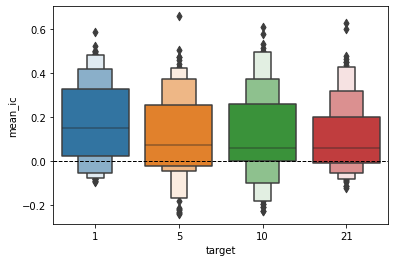

In [41]:
ax = sns.boxenplot(x='target', y='mean_ic', data=cross_val_results)
ax.axhline(0, ls='--', lw=1, c='k')

Now that we've grouped by target (the lookhead of our model) let's see that our previous hypothesis about
the best hyperparameters that we've done before are confirmed.

In [42]:
res_target.apply(lambda x: x.nlargest(3, 'mean_ic')).drop('target', axis=1)

train_length test_length n_estimators max_depth min_samples_leaf  \
target                                                                        
1      9           1260           5          100         5                5   
       7           1260           5          250      None               25   
       2           1260           5          250         5              100   
5      109         1260           5          100         5                5   
       106         1260           5          250         5               25   
       104         1260           5          100      None               25   
10     203         1260           5          250        15               25   
       205         1260           5          100        15              100   
       207         1260           5          250      None               25   
21     304         1260           5          100      None               25   
       309         1260           5          100         5                5   
       307         1260           5          250      None               25   

             mean_ic  std_ic rounds  
target                               
1      9    0.584962     0.0      1  
       7    0.523308     0.0      1  
       2    0.500752     0.0      1  
5      109  0.658647     0.0      1  
       106  0.505263     0.0      1  
       104  0.475188     0.0      1  
10     203  0.609023     0.0      1  
       205  0.578947     0.0      1  
       207  0.530827     0.0      1  
21     304  0.627068     0.0      1  
       309  0.600000     0.0      1  
       307  0.476692     0.0      1

In [43]:
res_std = cross_val_results[cross_val_results.std_ic != 0.0].groupby(by='target')
res_std.apply(lambda x: x.nsmallest(3, 'std_ic')).drop('target', axis=1)

train_length test_length n_estimators max_depth min_samples_leaf  \
target                                                                        
1      37           756          21          250      None               25   
       33           756          21          250        15               25   
       36           756          21          250         5               25   
5      125          756           5          100        15              100   
       138          756          21          250      None                5   
       122          756           5          250         5              100   
10     233          756          21          250        15               25   
       225          756           5          100        15              100   
       235          756          21          100        15              100   
21     336          756          21          250         5               25   
       333          756          21          250        15               25   
       326          756           5          250         5               25   

             mean_ic    std_ic rounds  
target                                 
1      37   0.310044  0.003493      2  
       33   0.336732  0.011289      2  
       36   0.348901  0.023965      2  
5      125  0.115038  0.005263      2  
       138  0.150491  0.010388      2  
       122  0.192481  0.010526      2  
10     233  0.358530  0.014154      2  
       225  0.036090  0.019549      2  
       235  0.163685  0.020686      2  
21     336  0.318599  0.011744      2  
       333  0.284540  0.014964      2  
       326  0.207519  0.018045      2

Guess what? Out hypothesis are confirmed!

The best models have all the best hyperparameters that we've identified before:

`{'n_estimators': 100, 'max_depth':15, 'min_samples_leaf': 100, train_length: 1260, test_length:21}`

In [44]:
base_params = rf_reg.get_params()
model = RandomForestRegressor(base_params)
model_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'max_features': 'log2',
    'min_samples_leaf': 5
}
model = model.set_params(**model_params)
opt_test_length = 21
opt_train_length = 1260

In [45]:
scores = np.array([])

for lookahead in lookaheads:
    n_splits = int(7 * YEAR /  (opt_test_length + opt_train_length))
    cv = MultipleTimeSeriesCV(
        n_splits=n_splits,
        test_period_length=opt_test_length,
        train_period_length=opt_train_length,
        lookahead=lookahead
    )

    for i, (train_idx, test_idx) in enumerate(cv.split(X)):
        model = model.fit(X.iloc[train_idx], y[f'target_{lookahead}d'].iloc[train_idx])

        y_test = y[f'target_{lookahead}d'].iloc[test_idx]
        y_pred = model.predict(X.iloc[test_idx])
        scores = np.append(scores, rank_correl(y_test, y_pred))
        print(f'Lookhead: {lookahead} | Iteration: {i} | Val score: {scores[-1]}')

Lookhead: 1 | Iteration: 0 | Val score: 0.40389610389610386
Lookhead: 5 | Iteration: 0 | Val score: 0.39610389610389607
Lookhead: 10 | Iteration: 0 | Val score: -0.11818181818181818
Lookhead: 21 | Iteration: 0 | Val score: 0.5311688311688313


## Evaluate the Best Model

In [46]:
y_test = data.filter(like='target').loc['2019': '2021']

y_test

,target_1d,target_5d,target_10d,target_21d
Date,,,,
2019-01-02,-0.004395,0.001752,0.013545,-0.003743
2019-01-03,0.033616,0.001625,0.014858,-0.004835
2019-01-04,-0.032852,0.003588,0.013534,-0.006365
2019-01-07,0.007812,0.040532,0.003214,-0.004783
2019-01-08,0.005730,0.033653,0.000437,-0.007168
...,...,...,...,...
2021-08-24,0.000257,0.023556,0.023485,0.011719
2021-08-25,0.073646,0.034399,0.025870,0.013270
2021-08-26,0.044455,0.020949,0.016707,0.014884


In [47]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_1d.values[-30:]))

0.11858938776241647


In [48]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_5d.values[-30:]))

0.3515407742300526


In [49]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_10d.values[-30:]))

0.5542329548145957


In [50]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_21d.values[-30:]))


0.6970742061156675


## Parameters importance

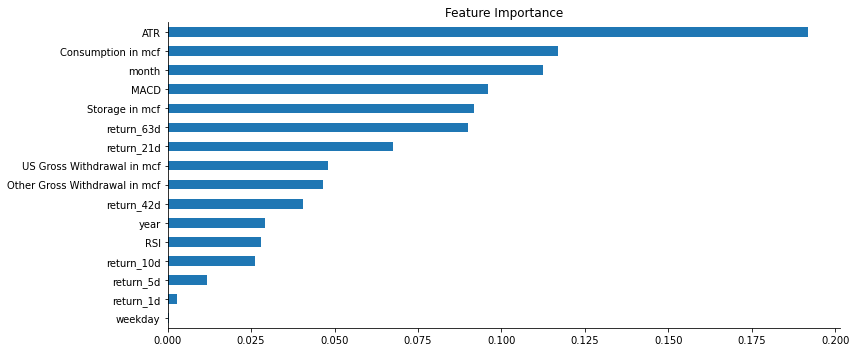

In [51]:

fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(model.feature_importances_, index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='Feature Importance'))

sns.despine()

fig.tight_layout();

Using the builtin `features_importances_` attribute from our model we can see that the most impactful params are:

- ATR
- NG consumption
- Other States Gross Withdrawal
- US Gross Withdrawal
- year
- MACD

To have a more holistic view of the importance of the features, we can use two others functions provided by
sklearn: `permutation_importance` and `partial_dependence`.

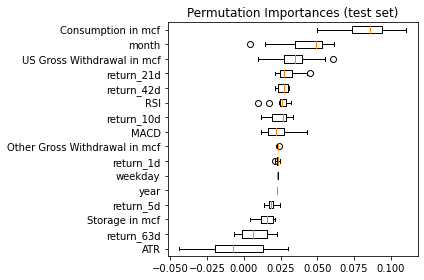

In [52]:
from sklearn.inspection import permutation_importance, partial_dependence

result = permutation_importance(model, X_test, y_test.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

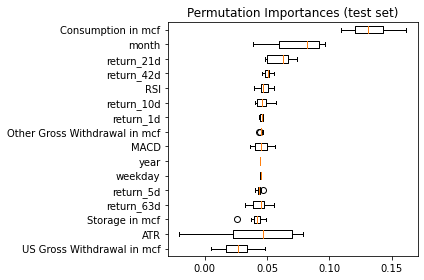

In [53]:
result = permutation_importance(model, X_test, y_test.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Partial dependence

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest,
marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

### Partial dependence between the ATR and MACD

What is really significant in the image below is the gap in the partial dependence values when the approaches values
between 0.16 and 0.14.

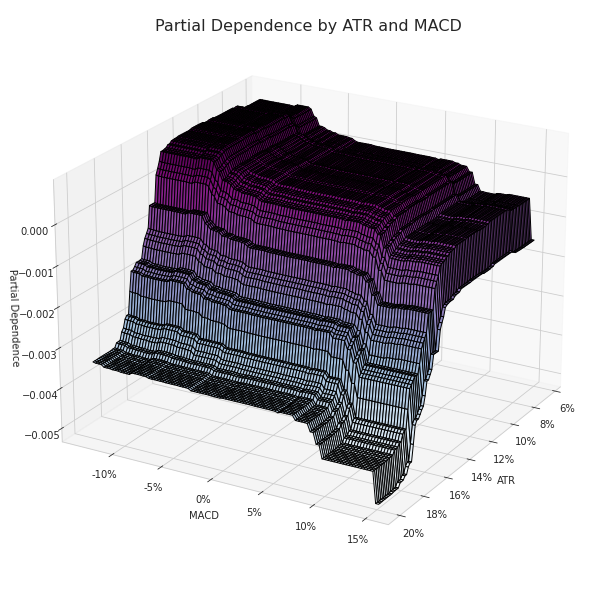

In [54]:
sns.set_style('whitegrid')
targets = ['ATR', 'MACD']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('ATR')
ax.set_ylabel('MACD')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by ATR and MACD', fontsize=16)
fig.tight_layout()

### Partial dependence between the Consumption and Storage

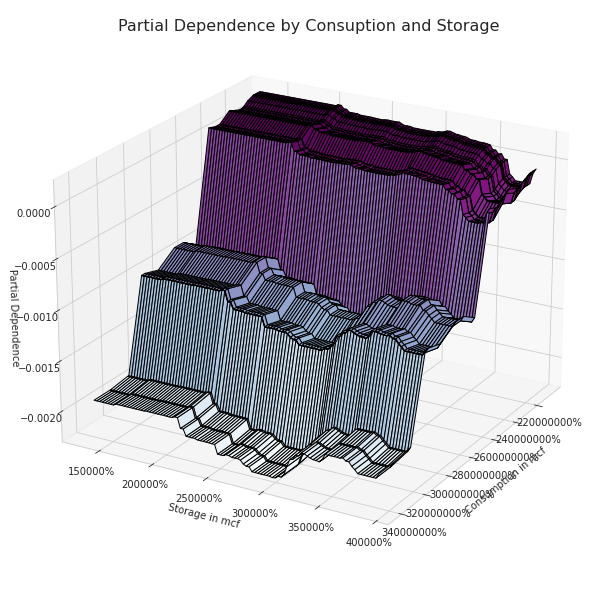

In [55]:
sns.set_style('whitegrid')
targets = ['Consumption in mcf', 'Storage in mcf']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('Consumption in mcf')
ax.set_ylabel('Storage in mcf')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by Consuption and Storage', fontsize=16)
fig.tight_layout()

### Partial Dependence between 10 and 21 return days

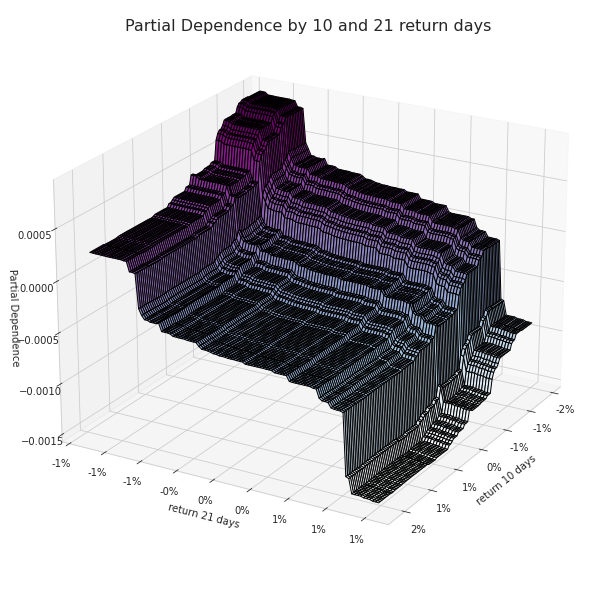

In [56]:
sns.set_style('whitegrid')
targets = ['return_10d', 'return_21d']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                    rstride=1,
                    cstride=1,
                    cmap=plt.cm.BuPu,
                    edgecolor='k')
ax.set_xlabel('return 10 days')
ax.set_ylabel('return 21 days')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by 10 and 21 return days', fontsize=16)
fig.tight_layout()

### Partial Dependence between 1 and 5 return days


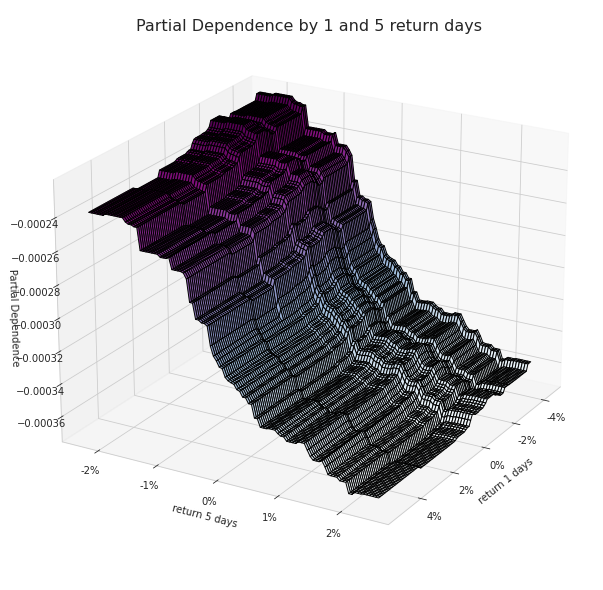

In [57]:
sns.set_style('whitegrid')
targets = ['return_1d', 'return_5d']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                    rstride=1,
                    cstride=1,
                    cmap=plt.cm.BuPu,
                    edgecolor='k')
ax.set_xlabel('return 1 days')
ax.set_ylabel('return 5 days')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by 1 and 5 return days', fontsize=16)
fig.tight_layout()

### Partial Dependence between NG Consuption and ATR

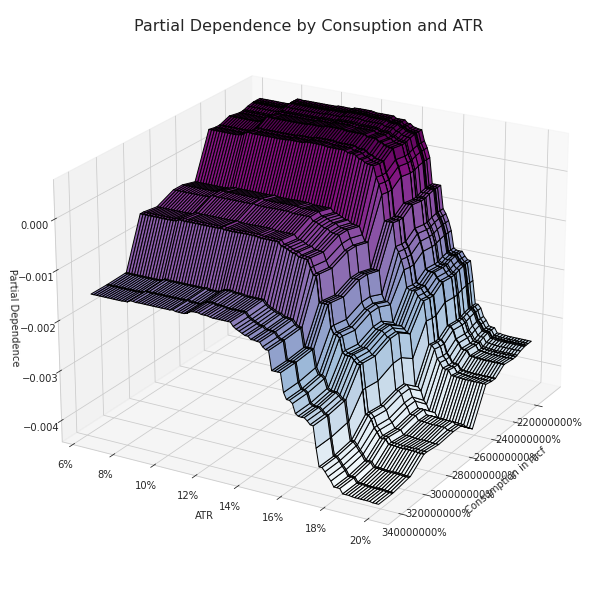

In [58]:
sns.set_style('whitegrid')
targets = ['Consumption in mcf', 'ATR']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('Consumption in mcf')
ax.set_ylabel('ATR')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by Consuption and ATR', fontsize=16)
fig.tight_layout()

Comparing the two most important features identified before (the ATR and the Consumption) we can clearly
we can see not only higher values but also a well-defined pattern regarding partial dependence.
As the ATR and the Consuption are approaching lower values the partial dependence grows, the opposite happens
when the opposite conditions occur.

## Shap Values

Shapley values originated in game theory as a technique for assigning a value to each player in a collaborative game
that reflects their contribution to the team's success. SHAP values are an adaptation of the game theory concept to
tree-based models and are calculated for each feature and each sample. They measure how a feature contributes to the
model output for a given observation. For this reason, SHAP values provide differentiated insights into how the impact
of a feature varies across samples, which is important given the role of interaction effects in these nonlinear models.



Shapley values are computed by introducing each feature, one at a time, into a conditional expectation function of the
model’s output, $$f_x(S) = \mathbb{E}[f(X) | do(X_s = x_s)]$$, and attributing the change produced at each step to the feature that was introduced; then averaging this process over all possible feature orderings.

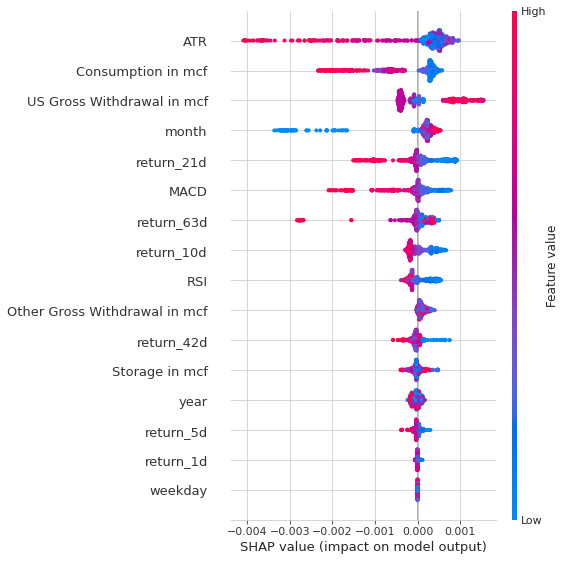

In [59]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X=X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()

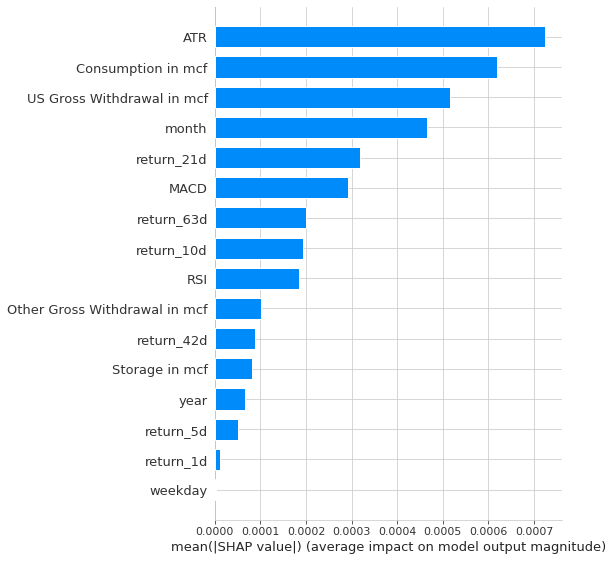

In [60]:

shap.summary_plot(shap_values, X_test, plot_type="bar",show=False)
plt.tight_layout()

The Shap values that we are seeing in the two images are confirming the most important features that
we've identified before, which are: ATR, Consumption, Other Gross Withdrawal, US Gross Withdrawal, year and
the MACD.

What Shap values are telling us more is how each feature is positively/negatively impact the output. We can see from
the first picture that:

- lower values of ATR usually lead to better returns, while when the ATR is higher the opposite tend to happend
- we can say the same thing about the Consumption
- earlier months often yield to worse result
- lower values of MACD are positively correlated to higher model output values, like the atr
- US Gross Withdrawal Values that have highly deviated from the mean tend to yield to positive returns, while closer values to mean often yield negative returns

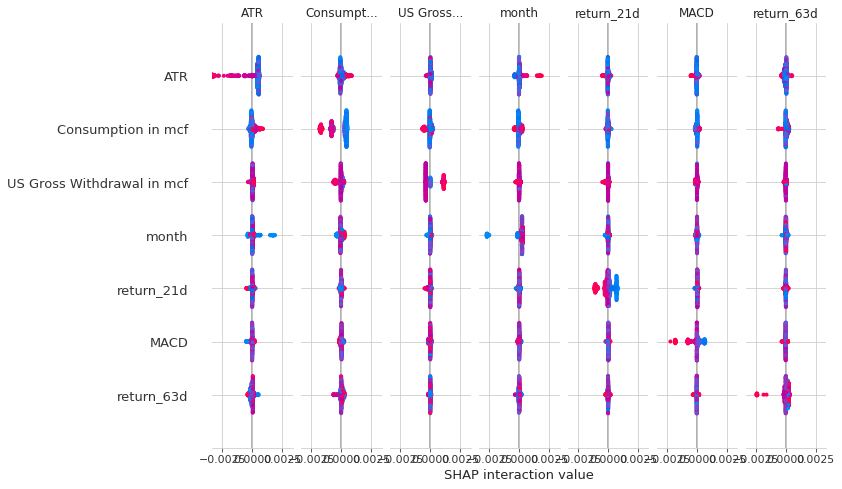

In [61]:
shap_interaction_values = explainer.shap_interaction_values(X_test)

shap.summary_plot(shap_interaction_values, X_test)

# Backtesting

In [62]:
backtest_data = data.loc['2019':'2021']

In [63]:
y_pred_test = model.predict(X_test)

In [64]:
y_pred_df = pd.DataFrame({'prediction': y_pred_test}, index=backtest_data.index)


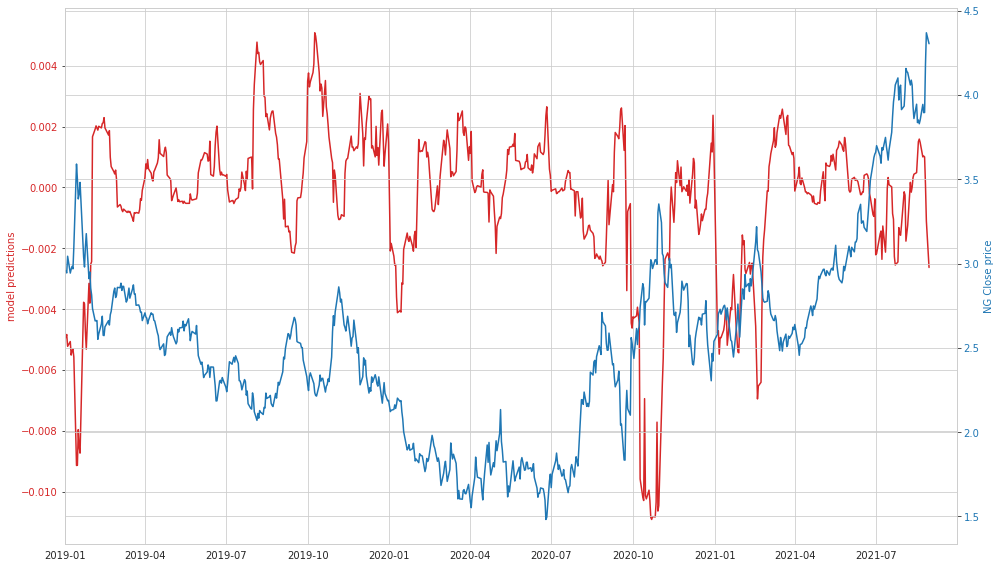

In [65]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:red'
ax1.plot(y_pred_df['prediction'], color=color)
ax1.set_ylabel('model predictions', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.plot(backtest_data.Close, color=color)
ax2.set_ylabel('NG Close price', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xlim(pd.Timestamp(year=2019, month=1, day=1), pd.Timestamp(year=2021, month=9, day=30))

fig.tight_layout()
plt.show()

In [66]:
import math

from scipy.signal import find_peaks

from backtesting import Backtest, Strategy

import tulipy as tu

Loading BokehJS ...

In [67]:
def return_indicator(values, data_len: int):
    a = np.empty((data_len - len(values),))
    a[:] = np.nan
    return np.concatenate([a, values])

def get_atr(data: pd.DataFrame, n: int):
    atr = tu.atr(data.High, data.Low, data.Close, n)
    return return_indicator(atr, len(data))

In [125]:
class RFModelStrategy(Strategy):
    risk = 5 # 5% of the total amount per trade
    pred_len = 12

    def init(self):
        super(RFModelStrategy, self).init()
        self.trailingATRLen = 5
        self.lookback = 3
        self.atrStopMultiplier = 1
        self.short_selling = True
        self.pointvalue = 10

        self.model = model
        self.atr = self.I(get_atr, self.data, 14, plot=False)
        self.trailingAtr = self.I(get_atr, self.data, self.trailingATRLen, plot=False)
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast', color='red')

    def get_signal(self, predictions):
        if np.sum(predictions < 0, axis=0) / self.pred_len > 0.75:
            neg_peaks, _ = find_peaks(-predictions)
            peaks, _ = find_peaks(predictions)

            if len(neg_peaks) != 0 and neg_peaks[-1] <= self.pred_len - 2:
                return 'Sell'

        elif np.sum(predictions > 0, axis=0) / self.pred_len > 0.75:
            peaks, _ = find_peaks(predictions)

            if len(peaks) != 0 and peaks[-1] <= self.pred_len - 2:
                return 'Buy'

        return 'No signal'

    def next(self):
        X, _ = get_X_y(self.data.df)
        predictions = self.model.predict(X[-self.pred_len:])

        self.forecasts[-1] = self.model.predict(X[-2:])[0]

        if len(self.trades) == 0:
            signal = self.get_signal(predictions)

            if signal == 'Sell':
                self.sell(size=self.get_position_size())
            elif signal == 'Buy':
                self.buy(size=self.get_position_size())
        else:

            signal = self.get_signal(predictions)

            if self.trades[0].is_long:
                if signal == 'Sell' or \
                        self.data.Low[-1] <= self.get_trailing_stop(long=True):
                    self.position.close()
                    if signal == 'Sell':
                        self.sell(size=self.get_position_size())
            else:
                if signal == 'Buy' or \
                        self.data.High[-1] >= self.get_trailing_stop(long=False):
                    self.position.close()
                    if signal == 'Buy':
                        self.buy(size=self.get_position_size())

    def get_position_size(self):
        return math.floor((self.risk / 100 * self.equity) / (self.atr * self.pointvalue))

    def get_trailing_stop(self, long: bool):
        if long:
            return np.max(self.data.Low[-self.lookback:]) - self.trailingAtr[-1] * self.atrStopMultiplier
        else:
            return np.min(self.data.High[-self.lookback:]) + self.trailingAtr[-1] * self.atrStopMultiplier

In [126]:
bt = Backtest(backtest_data, RFModelStrategy, cash=250_000, trade_on_close=True, commission=0.02)

stats = bt.run()

stats

Start                     2019-01-02 00:00:00
End                       2021-08-30 00:00:00
Duration                    971 days 00:00:00
Exposure Time [%]                   86.587183
Equity Final [$]                 266572.53144
Equity Peak [$]                  277702.83774
Return [%]                           6.629013
Buy & Hold Return [%]               45.537525
Return (Ann.) [%]                     2.43983
Volatility (Ann.) [%]                 4.90996
Sharpe Ratio                         0.496914
Sortino Ratio                        0.750249
Calmar Ratio                         0.277013
Max. Drawdown [%]                   -8.807635
Avg. Drawdown [%]                   -0.954293
Max. Drawdown Duration      664 days 00:00:00
Avg. Drawdown Duration       48 days 00:00:00
# Trades                                   52
Win Rate [%]                        44.230769
Best Trade [%]                      34.636961
Worst Trade [%]                    -18.773294
Avg. Trade [%]                    

In [127]:
bt.plot(filename='./tree_regressor_backtesting.html')

Row(id='20393', ...)

TODO:

- [x] Update model data with new data
- [x] Held out a test set used to testing (between 30% and 20% of the total data) and for compute feature importance
- [x] retrain the model
- [x] Backtest the model using backtesting.py
- [ ] Control comments

# References

- [NHANES I Survival Model](https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html#NHANES-I-Survival-Model)
- [Long-Short Strategy, Part 4: How to interpret GBM results](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/12_gradient_boosting_machines/07_model_interpretation.ipynb)